In [1]:
import numpy as np
import gym, random, copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

class Actor(nn.Module):
    def __init__(self, n_dim_states, n_dim_actions, action_bound, lr):
        super(Actor, self).__init__()
        self.action_bound = action_bound
        self.lin1 = nn.Linear(n_dim_states, 400)
        self.lin2 = nn.Linear(400, 300)
        self.lin3 = nn.Linear(300, n_dim_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, X):
        X = F.relu(self.lin1(X))
        X = F.relu(self.lin2(X))
        return self.action_bound * F.tanh(self.lin3(X))

class Critic(nn.Module):
    def __init__(self, n_dim_states, n_dim_actions, lr):
        super(Critic, self).__init__()
        self.lin1 = nn.Linear(n_dim_states + n_dim_actions, 400)
        self.lin2 = nn.Linear(400, 300)
        self.lin3 = nn.Linear(300, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, X):
        X = F.relu(self.lin1(X))
        X = F.relu(self.lin2(X))
        return self.lin3(X)

class Agent:
    def __init__(self, n_dim_states, n_dim_actions, action_bound, gamma=0.99, 
                 eps=0.4, batch_size=64, mem_capacity=1e6, actor_lr=1e-4,
                 critic_lr=1e-3, target_lr=1e-3):
        self.n_dim_states = n_dim_states
        self.n_actions = n_dim_actions
        self.gamma = gamma
        self.eps = eps
        self.batch_size = batch_size
        self.target_lr = target_lr

        self.actor = Actor(n_dim_states, n_dim_actions, action_bound, actor_lr)
        self.critic = Critic(n_dim_states, n_dim_actions, critic_lr)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        
        # List of past samples (state, action, reward, next_state)
        self.memory = []
        self.mem_capacity = mem_capacity
        
    def policy(self, state):
        var_state = Variable(torch.Tensor(state.reshape(1, -1)))
        action = self.actor(var_state).data.numpy().reshape(-1)
        return action
    
    def behavior_policy(self, state):
        deterministic_action = self.policy(state)
        return deterministic_action + self.eps * np.random.randn()

    def observe(self, sample):
        # Add sample to memory, and delete one sample if capacity exceeded
        self.memory.append(sample)
        if (len(self.memory) > self.mem_capacity):
            self.memory.pop(0)

    def experience_replay(self):
        # Sample a batch from memory uniformly at random 
        batch_size = min(self.batch_size, len(self.memory))
        batch = np.array(random.sample(self.memory, batch_size))
        
        states = Variable(torch.FloatTensor(np.vstack(batch[:, 0])))
        actions = Variable(torch.FloatTensor(np.vstack(batch[:, 1])))
        rewards = Variable(torch.FloatTensor(np.vstack(batch[:, 2])))
        next_states = Variable(torch.FloatTensor(np.vstack(batch[:, 3])))
        
        # Improve critic
        Q_values = self.critic(torch.cat((states, actions), dim=1))
        next_actions = self.target_actor(next_states)
        next_Q_values = self.target_critic(torch.cat((next_states, next_actions), dim=1))
        targets = rewards + self.gamma * next_Q_values
        targets = targets.detach() # We don't want the gradient w.r.t the targets
                                    
        critic_loss = nn.MSELoss()(Q_values, targets)
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()
                   
        # Improve actor
        actions = self.actor(states)
        Q_values = self.critic(torch.cat((states, actions), dim=1))
        
        actor_loss = -Q_values.mean()
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()
        
        # Update target networks towards current networks
        self._update_target_networks()
        
    def _update_target_networks(self):
        current_params = list(self.critic.parameters()) + list(self.actor.parameters())
        target_params = list(self.target_critic.parameters()) + list(self.target_actor.parameters())
        for current, target in zip(current_params, target_params):
            target.data = self.target_lr * current.data + (1. - self.target_lr) * target.data

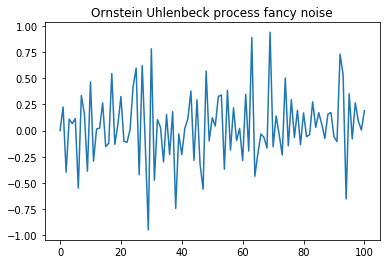

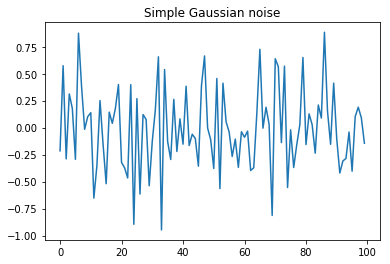

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

class Noise(object):
    def __init__(self, delta=0.5, sigma=0.5, ou_a=3., ou_mu=0.):
        self.delta = delta
        self.sigma = sigma
        self.ou_a = ou_a
        self.ou_mu = ou_mu

    def brownian_motion_log_returns(self):
        """
        This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
        about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
        :return: brownian motion log returns
        """
        sqrt_delta_sigma = np.sqrt(self.delta) * self.sigma
        return np.random.normal(loc=0, scale=sqrt_delta_sigma, size=None)

    def ornstein_uhlenbeck_level(self, prev_ou_level):
        """
        This method returns the rate levels of a mean-reverting ornstein uhlenbeck process.
        :return: the Ornstein Uhlenbeck level
        """
        drift = self.ou_a * (self.ou_mu - prev_ou_level) * self.delta
        randomness = self.brownian_motion_log_returns()
        return prev_ou_level + drift + randomness

ou_level= 0.
noise = Noise()
noise_levels = [ou_level]
for x in range(100):
    ou_level = noise.ornstein_uhlenbeck_level(ou_level)
    noise_levels.append(ou_level)
plt.plot(range(len(noise_levels)), noise_levels)
plt.title("Ornstein Uhlenbeck process fancy noise")
plt.show()

# Simple Gaussian noise very similar to fancy noise from DDPG paper
noise_levels = []
for x in range(100):
    noise_levels.append(0.4 * np.random.randn())
plt.plot(range(len(noise_levels)), noise_levels)
plt.title("Simple Gaussian noise")
plt.show()

In [3]:
class Environment:
    def __init__(self, environment, noise_max_ep=150):
        self.env = gym.make(environment)
        self.noise_max_ep = noise_max_ep
        self.n_episodes = 0

    def run_episode(self, agent, render=False):
        self.n_episodes += 1
        state = self.env.reset()
        n_steps = 0
        total_reward = 0
        while True: 
            if render:
                self.env.render()
            # For the first noise_max_ep episodes, add random noise to the action
            if self.n_episodes < self.noise_max_ep:
                action = agent.behavior_policy(state)
            else:
                action = agent.policy(state)
            next_state, reward, done, info = self.env.step(action)
            if done:
                next_state = np.zeros(self.env.observation_space.shape[0])
            agent.observe((state, action, reward, next_state))
            agent.experience_replay()
            state = next_state
            n_steps += 1
            total_reward += reward
            if done:
                return(total_reward, n_steps)

In [4]:
from tensorboardX import SummaryWriter

"""
# 2 hidden layers of dimensions 400 and 300 for actor and critic
# experience replay after each step
# takes around 100 episodes to reach close to optimal policy
GAMMA = 0.99
EPS = 0.4
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
LR_TARGET = 1e-3
BATCH_SIZE = 64
MEM_CAPACITY = 1e6 
NOISE_MAX_EP = 100
env = Environment('Pendulum-v0', noise_max_ep=NOISE_MAX_EP)
"""

# 2 hidden layers of dimensions 400 and 300 for actor and critic
# experience replay after each step
# takes around 2000 episodes to good policy 
# avg reward 1100, best reward 3000, mean num steps 300, std num steps 200
# experience catastrophic forgetting right after
GAMMA = 0.99
EPS = 0.4
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
LR_TARGET = 1e-3
BATCH_SIZE = 64
MEM_CAPACITY = 1e6
NOISE_MAX_EP = 3000
env = Environment('Hopper-v2', noise_max_ep=NOISE_MAX_EP)

print(env.env.action_space)
print(env.env.action_space.low)
print(env.env.action_space.high)

n_dim_states = env.env.observation_space.shape[0]
n_actions = env.env.action_space.shape[0]
action_bound = float(env.env.action_space.high[0])
agent = Agent(n_dim_states, n_actions, action_bound, gamma=GAMMA,
              eps=EPS, batch_size=BATCH_SIZE, mem_capacity=MEM_CAPACITY,
              actor_lr=LR_ACTOR, critic_lr=LR_CRITIC, target_lr=LR_TARGET)

writer = SummaryWriter("log_files/Hopper")
rewards = []
n_steps = []
print_every = 50
while(True):
    reward, n_step = env.run_episode(agent)
    rewards.append(reward)
    n_steps.append(n_step)
    if env.n_episodes % print_every == 1:
        r = np.array(rewards[-print_every:])
        s = np.array(n_steps[-print_every:])
        #print("Episode {}".format(env.n_episodes))
        #print("Rewards: mean=%.2f, min=%.2f, max=%.2f, std=%.2f" % (r.mean(), r.min(), r.max(), r.std()))
        #print("Number of steps: mean=%d, std=%.2f" % (s.mean(), s.std()))
        writer.add_scalar("Reward/Mean", r.mean(), env.n_episodes)
        writer.add_scalar("Reward/Max", r.max(), env.n_episodes)
        writer.add_scalar("Reward/Min", r.min(), env.n_episodes)
        writer.add_scalar("Reward/Std", r.std(), env.n_episodes)
        writer.add_scalar("Numsteps/Mean", s.mean(), env.n_episodes)
        writer.add_scalar("Numsteps/Min", s.max(), env.n_episodes)
        writer.add_scalar("Numsteps/Max", s.min(), env.n_episodes)
        writer.add_scalar("Numsteps/Std", s.std(), env.n_episodes)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Box(3,)
[-1. -1. -1.]
[1. 1. 1.]


KeyboardInterrupt: 